In [ ]:
# ==== 0) Paths, seeding, and discovery ====
from pathlib import Path
import glob, random, math
from collections import defaultdict, Counter

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

def seed_everything(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed); torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

ROOT = Path.cwd()
while not (ROOT / "data").exists() and ROOT.parent != ROOT:
    ROOT = ROOT.parent

DATA_DIR = ROOT / "data" / "paired_dataset_art"   # change if needed
print("ROOT:", ROOT)
print("DATA_DIR:", DATA_DIR)

# Discover files by class (case must match your folders)
CLASS_TO_IDX = {"undamaged": 0, "damaged": 1}
IDX_TO_CLASS = {v:k for k,v in CLASS_TO_IDX.items()}

files_by_class = {c: sorted(glob.glob(str(DATA_DIR/c/"*.*"))) for c in CLASS_TO_IDX}
counts = {c: len(files_by_class[c]) for c in CLASS_TO_IDX}
print("Class counts:", counts)
assert sum(counts.values()) > 0, f"No images found under {DATA_DIR}"


ROOT: c:\Users\vs.naga\Documents\ML_proj\aml
DATA_DIR: c:\Users\vs.naga\Documents\ML_proj\aml\data\paired_dataset_art
Class counts: {'undamaged': 210, 'damaged': 323}


In [28]:
# ==== 1) Stratified split (train/val/test) ====
def stratified_split(files_by_class, ratios=(0.7, 0.15, 0.15), seed=42):
    """Return dict with 'train','val','test' lists, stratified per class."""
    assert abs(sum(ratios) - 1.0) < 1e-6
    rnd = random.Random(seed)
    split = {"train": [], "val": [], "test": []}
    for cls, files in files_by_class.items():
        f = files.copy()
        rnd.shuffle(f)
        n = len(f)
        n_train = int(round(ratios[0] * n))
        n_val   = int(round(ratios[1] * n))
        # ensure we don’t exceed n
        if n_train + n_val > n: n_val = max(0, n - n_train)
        n_test  = n - n_train - n_val
        split["train"] += f[:n_train]
        split["val"]   += f[n_train:n_train+n_val]
        split["test"]  += f[n_train+n_val:]
    # shuffle each bucket
    for k in split: rnd.shuffle(split[k])
    return split

splits = stratified_split(files_by_class, ratios=(0.7, 0.15, 0.15), seed=42)
for k in splits:
    lab = [Path(p).parent.name for p in splits[k]]
    print(f"{k}: {len(lab)} | {Counter(lab)}")


train: 373 | Counter({'damaged': 226, 'undamaged': 147})
val: 80 | Counter({'damaged': 48, 'undamaged': 32})
test: 80 | Counter({'damaged': 49, 'undamaged': 31})


In [29]:
# ==== 2) Transforms ====
SIZE = 256
train_tfms = transforms.Compose([
    transforms.Resize(SIZE),
    transforms.CenterCrop(SIZE),
    # light augments; comment out if you want pure baseline
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
])
eval_tfms = transforms.Compose([
    transforms.Resize(SIZE),
    transforms.CenterCrop(SIZE),
    transforms.ToTensor(),
])


In [30]:
# ==== 3) Dataset ====
class ArtFolderDataset(Dataset):
    def __init__(self, file_list, class_to_idx=CLASS_TO_IDX, transform=eval_tfms):
        self.files = list(file_list)
        self.class_to_idx = class_to_idx
        self.transform = transform

    def __len__(self): return len(self.files)

    def __getitem__(self, i):
        p = self.files[i]
        x = Image.open(p).convert("RGB")
        x = self.transform(x)     # (3,H,W) float [0,1]
        y = self.class_to_idx[Path(p).parent.name.lower()]
        return x, y


In [33]:
# ==== 4) DataLoaders ====
BATCH_SIZE = 16
NUM_WORKERS = 0  # set 0 on Windows if you hit spawn issues

train_ds = ArtFolderDataset(splits["train"], transform=train_tfms)
val_ds   = ArtFolderDataset(splits["val"],   transform=eval_tfms)
test_ds  = ArtFolderDataset(splits["test"],  transform=eval_tfms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True, drop_last=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)

len(train_ds), len(val_ds), len(test_ds)


(373, 80, 80)

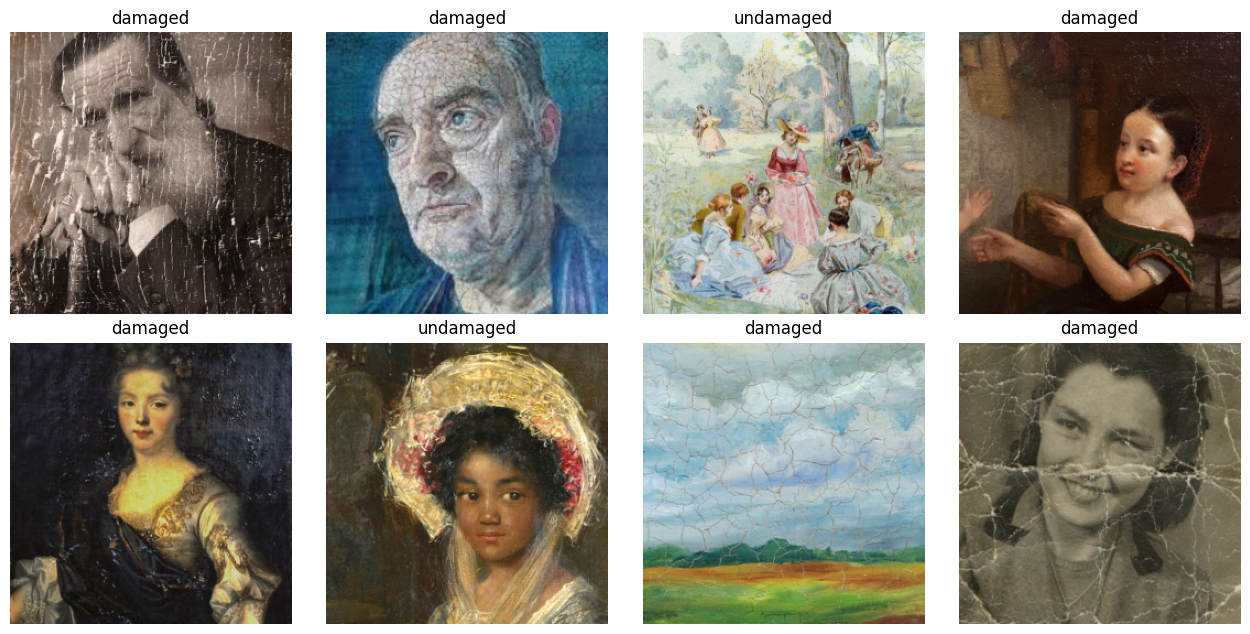

class weights (train): [3.818877667072229e-05, 2.4839600882842205e-05]


In [34]:
# ==== 5) Helpers: visualize a batch & compute class weights ====
def show_batch(loader, n=8):
    """Show n images from the first batch of a loader."""
    import matplotlib.pyplot as plt
    x,y = next(iter(loader))
    x = x[:n]; y = y[:n]
    cols = min(n, 4); rows = math.ceil(n/cols)
    fig, axs = plt.subplots(rows, cols, figsize=(3.2*cols, 3.2*rows))
    axs = np.array(axs).reshape(-1)
    for i,(img,yy) in enumerate(zip(x, y)):
        axs[i].imshow(img.permute(1,2,0))
        axs[i].set_title(IDX_TO_CLASS[int(yy)])
        axs[i].axis("off")
    for j in range(i+1, len(axs)): axs[j].axis("off")
    plt.tight_layout(); plt.show()

def class_weights_from_dataset(file_list, class_to_idx=CLASS_TO_IDX):
    """Inverse-frequency weights for CE loss if classes are imbalanced."""
    labs = [class_to_idx[Path(p).parent.name.lower()] for p in file_list]
    cnts = Counter(labs)
    weights = []
    for i in range(len(class_to_idx)):
        w = 1.0 / max(cnts.get(i, 1), 1)
        weights.append(w)
    # normalize
    s = sum(weights); weights = [w*s/len(weights) for w in weights]
    return torch.tensor(weights, dtype=torch.float32)

# Quick checks
show_batch(train_loader, n=8)
cw = class_weights_from_dataset(splits["train"])
print("class weights (train):", cw.tolist())
